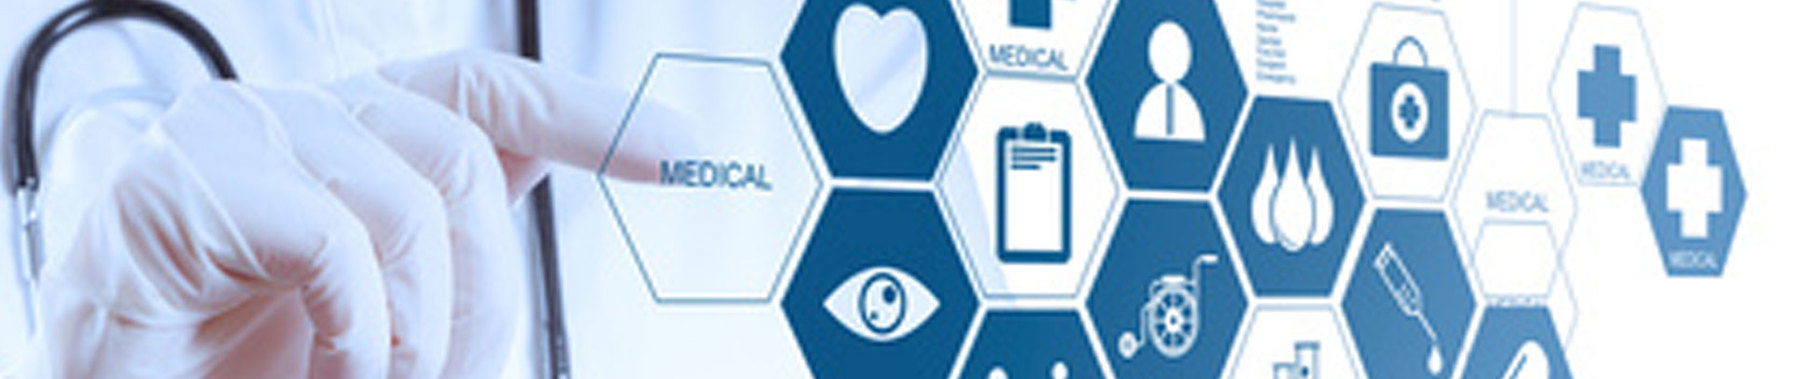

# Medical Cost Personal Datasets

## Insurance Forecast by using Linear Regression

Здесь мы коснёмся мира медицинского страхования.<br>
Нашей целью будет предсказать индивидуальные медицинские расходы граждан США, оплачиваемые медицинской страховкой.

Работать будем с популярным датасетом [Medical Cost Personal Datasets](https://www.kaggle.com/mirichoi0218/insurance).

In [1]:
# Подгрузим весь необходимый инструментарий.

import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn.model_selection import train_test_split # разделение выборки

---

## Знакомство с данными

---

In [2]:
# Загрузим датасет и взглянем на первые строки таблицы.
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Итак, набор данных содержит следующие столбцы:

|признак|описание|
|-|-|
|age|возраст страхователя|
|sex|пол|
|bmi|индекс массы тела (кг/м<sup>2</sup>), в идеале — от 18.5 до 24.9|
|children|количество детей, охваченных медицинской страховкой|
|smoker|является ли человек курящим|
|region|район проживания в США (северо-восток, юго-восток, северо-запад, юго-запад)|
|charges (целевой признак)|индивидуальные медицинские расходы, оплачиваемые медицинской страховкой|

In [3]:
# Размер таблицы.
print(data.shape)

(1338, 7)


In [4]:
# Выведем информацию о пропусках, так как наличие пропусков
# не позволит нам построить модель линейной регрессии.
display(data.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Пропуски в таблице отсутствуют.

In [5]:
# Посмотрим на типы данных.
display(data.dtypes)

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

Наши данные содержат несколько типов признаков:

|признак|тип|
|-|-|
|*age, bmi, children*|числовые признаки|
|*sex, smoker*|бинарные категориальные переменные (две категории)|
|*region*|множественные категориальные переменные (несколько категорий)|
|*charges*|числовой целевой признак|

---

## Анализ данных

---

Прежде чем приступать к этапу подготовки данных для модели, мы можем произвести небольшое исследование зависимостей в данных, например построить следующие графики и диаграммы:

  * гистограммы числовых признаков;
  * столбчатые диаграммы медианных медицинских расходов в зависимости от категориальных признаков;
  * диаграммы рассеяния зависимости целевого признака от других числовых в разрезе категориальных.

In [6]:
# Зенесем названия числовых признаков в список.
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'bmi', 'children', 'charges']

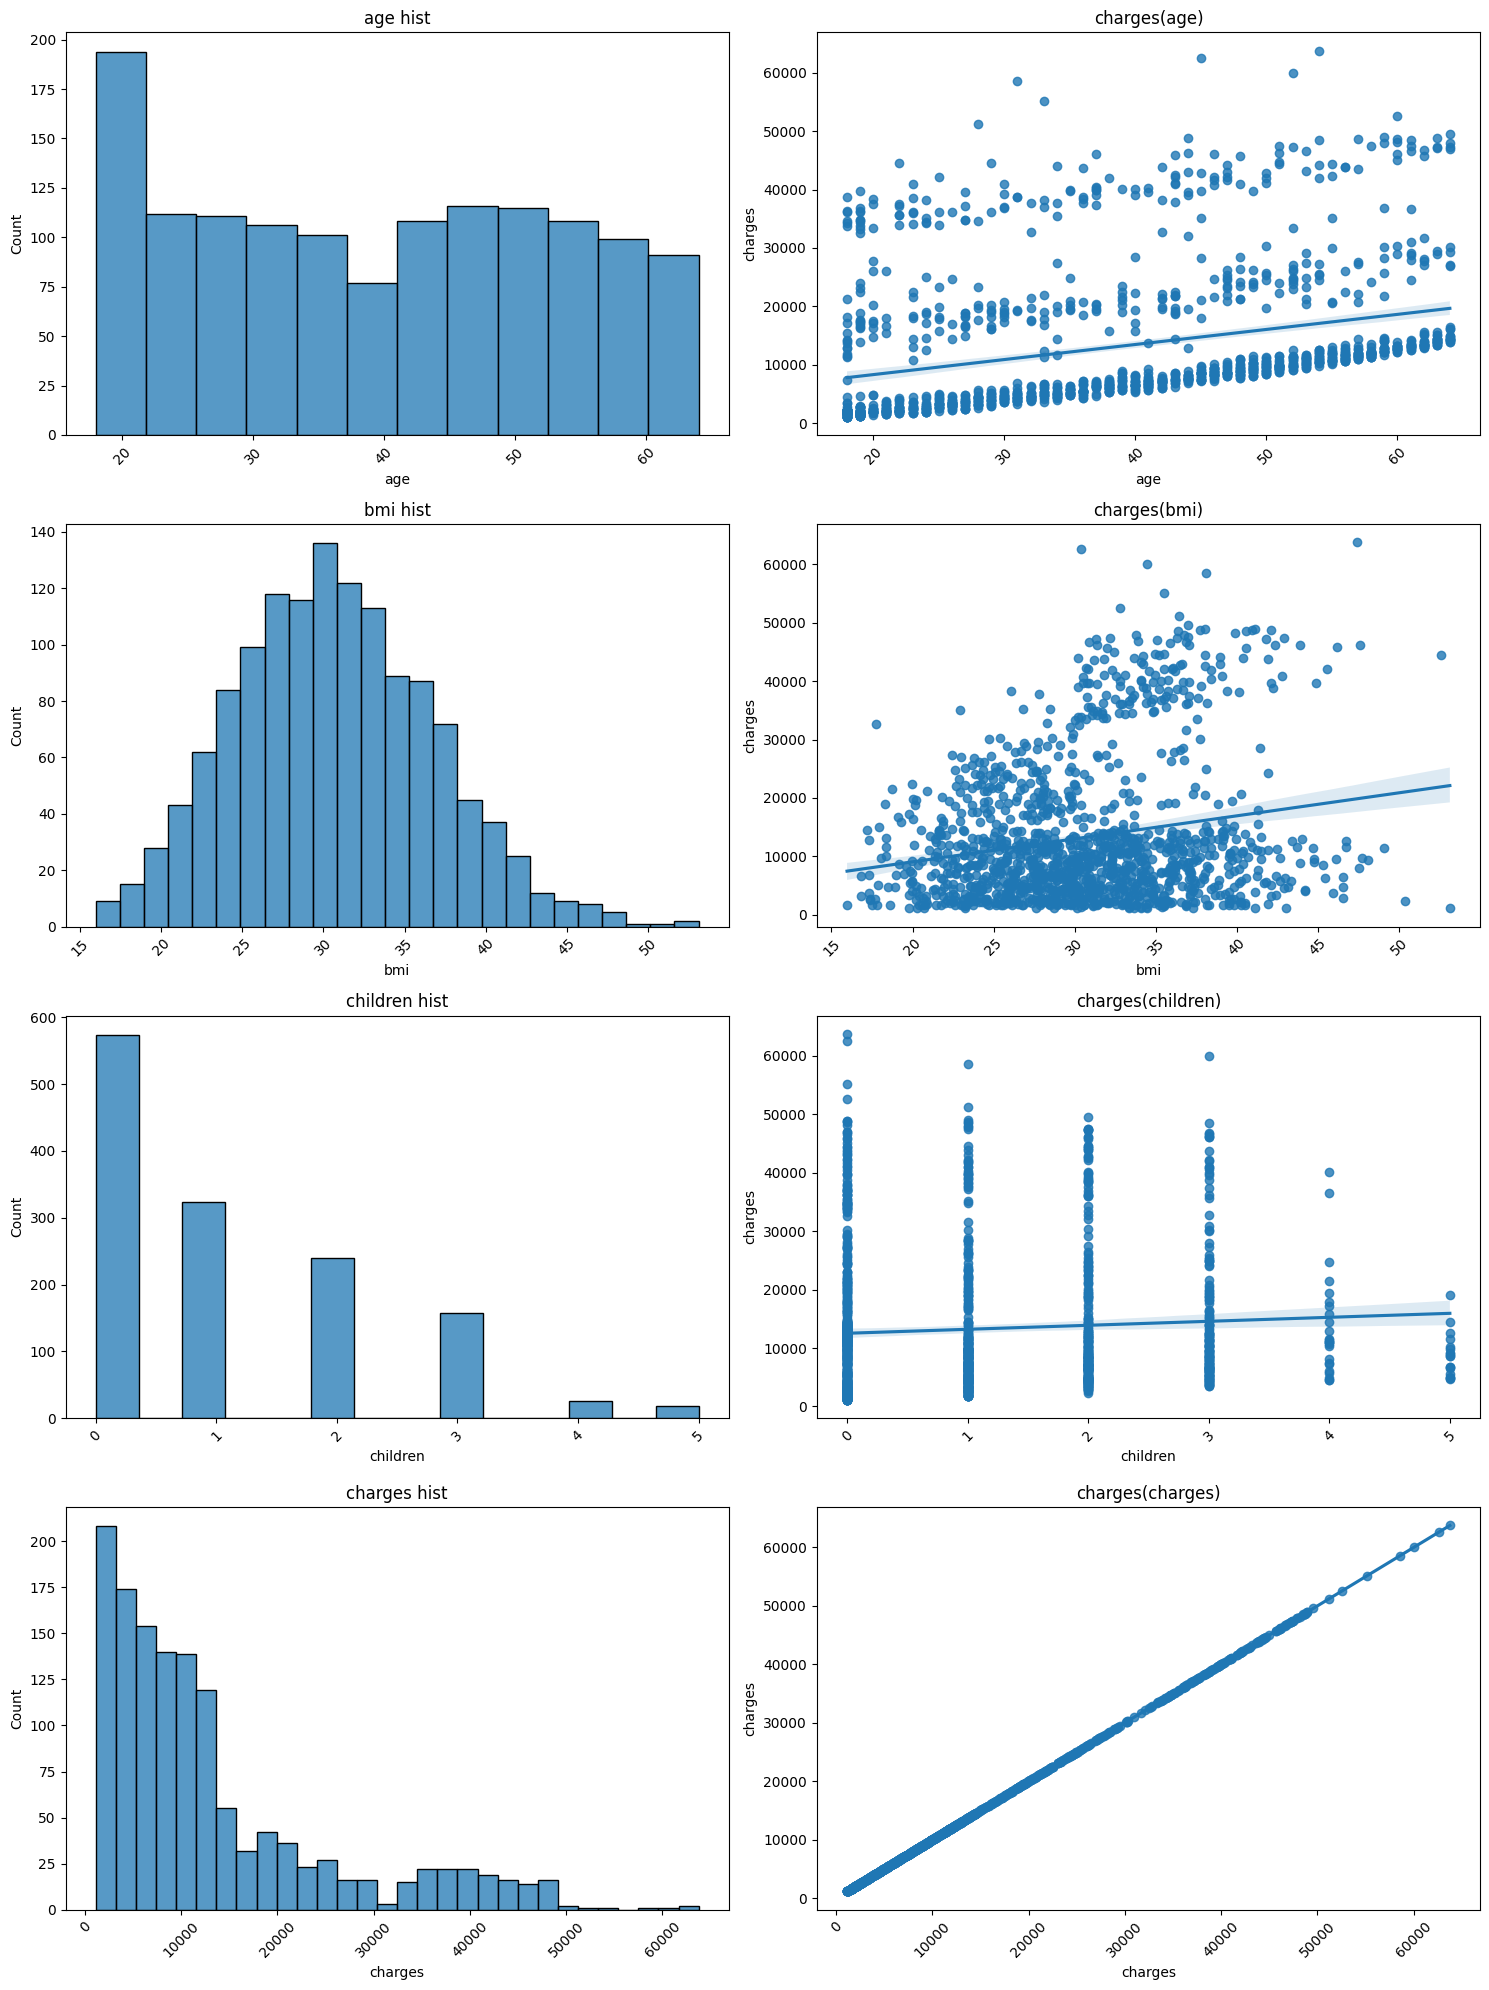

In [7]:
# Визуализируем распределения признаков.
n = len(num_features) # Количество числовых признаков.
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # Фигура + n х 2 координатных плоскостей.
# Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): # i- индекс, feature - название признака в таблице
    # Строим гистограмму распределения признака .
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    # Добавляем подпись графику.
    histplot.set_title('{} hist'.format(feature))
    # Добавляем поворот отметок на оси абсцисс.
    histplot.xaxis.set_tick_params(rotation=45)
    # Строим диаграмму рассеяния + линейную регрессию.
    regplot = sns.regplot(data=data, x=feature, y='charges', ax=axes[i][1])
    # Добавляем подпись графику.
    regplot.set_title('charges({})'.format(feature));
    # Добавляем поворот отметок на оси абсцисс.
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() # Выравнивание графиков.

Единственный нормально распредленный признак - ИМС. Имеет любопытное распределение на диаграмме рассеяния.<br>
Чуть более интересно выглядит рассение значений возраста: мы можем хорошо определить три группы людей: возможно, здесь выялвляется действие третьего, неопределенного в датасете, признака, им,например, может быть тип страховки.

In [8]:
# Зенесем названия категориальных признаков в соответствующий список.
obj_features = list(types[(types == 'object')].index)
obj_features

['sex', 'smoker', 'region']

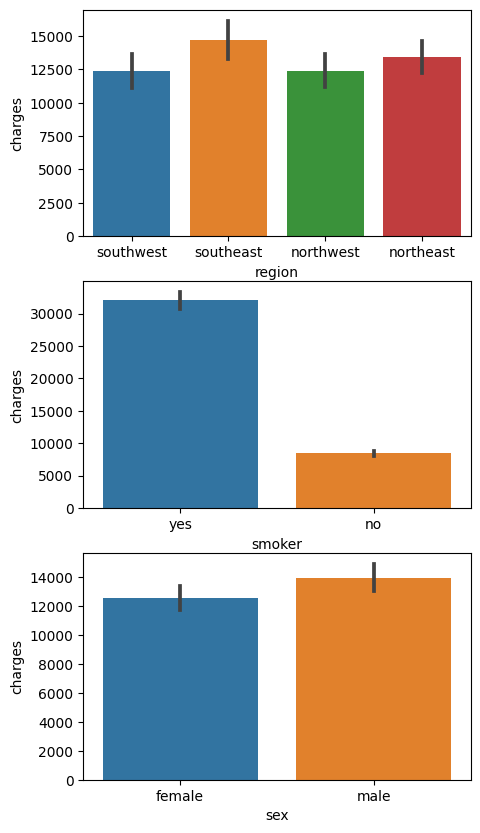

In [9]:
# Визуализируем зависимости средних расходов от категориальных признаков.
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
sns.barplot(data=data, x='region', y='charges', ax=axes[0])
sns.barplot(data=data, x='smoker', y='charges', ax=axes[1])
sns.barplot(data=data, x='sex', y='charges', ax=axes[2]);

1) Здесь мы можем заключить, что южане в среднем тратятся на страховку больше всех, следом идут северяне, на остальных, можно сказать, влияние региональных широт одинаковое: долгая жара или холод, широкий температурный перепад в зависимости от сезона - все это может плохо сказываться на состоянии организма с течением времени.<br>
2) Курящие минимум втрое больше тратят на медстраховку: разумеется, потому, что риск развития заболеваний здесь больше.<br>
3) Мужчины в среднем тратят на страховку больше женщин: скорее всего, потому, что они чаще привлекаются к физически опасному труду.

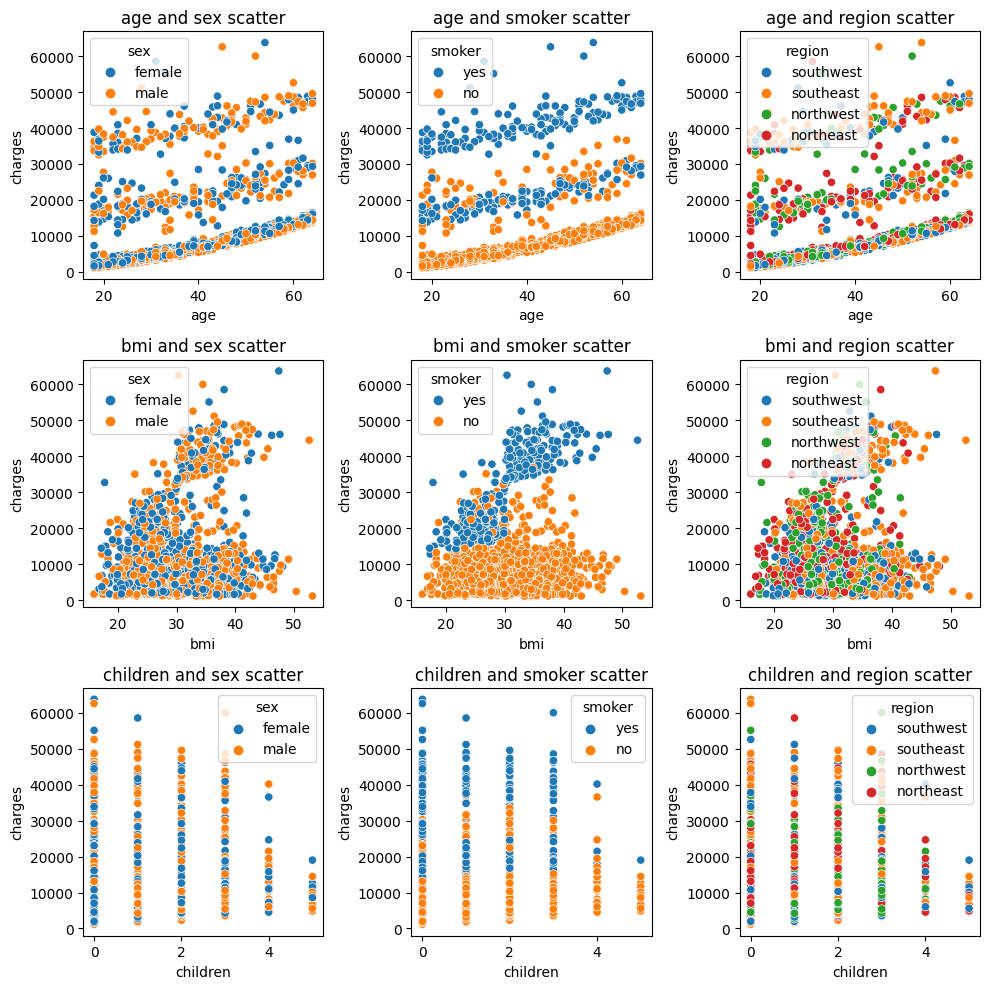

In [10]:
# Удалим расходы из списка числовых признаков:
# так удобнее осуществить перебор значений в цикле.
num_features.remove('charges')
n, m = len(num_features), len(obj_features)
fig, axes = plt.subplots(n, m, figsize=(10, 10))
# Создаем двойной цикл для всех признаков из обоих списков.
for i, n_feature in enumerate(num_features):
    for j, o_feature in enumerate(obj_features):
        # Создаем диаграмму рассеяния зависимости
        # целевого признака от других числовых в разрезе категориальных.
        scatterplot = sns.scatterplot(
            data=data,
            x=n_feature,
            y='charges',
            hue=o_feature,
            ax=axes[i][j]
        )
        scatterplot.set_title(f'{n_feature} and {o_feature} scatter')
plt.tight_layout()

В разрезе пола зависимости от числовых признаков не дают заметных закономерностей.<br>
Чего не скажешь о распределениях в зависимости от курения: замечанная нами ранее аномалия в рассеянии значений ИМС может быть объяснена тем, что после 30 курящие, видимо, перезаключают страховые соглашения.<br>
В разрезе региона проживания заметных закономерностей также, пожалуй, наблюдается не особо.

---

## Подготовка данных

---

Мы знаем, что модель линейной регрессии не умеет работать с категориальными признаками, поэтому категории необходимо перекодировать.

In [11]:
# Кодируем бинарные категориальные признаки.
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)
# Оставшиеся категориальные признаки кодируем с помощью OneHot.
data = pd.get_dummies(data)
data.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


Итак, мы получили перекодированную таблицу, в которой все признаки являются числовыми.

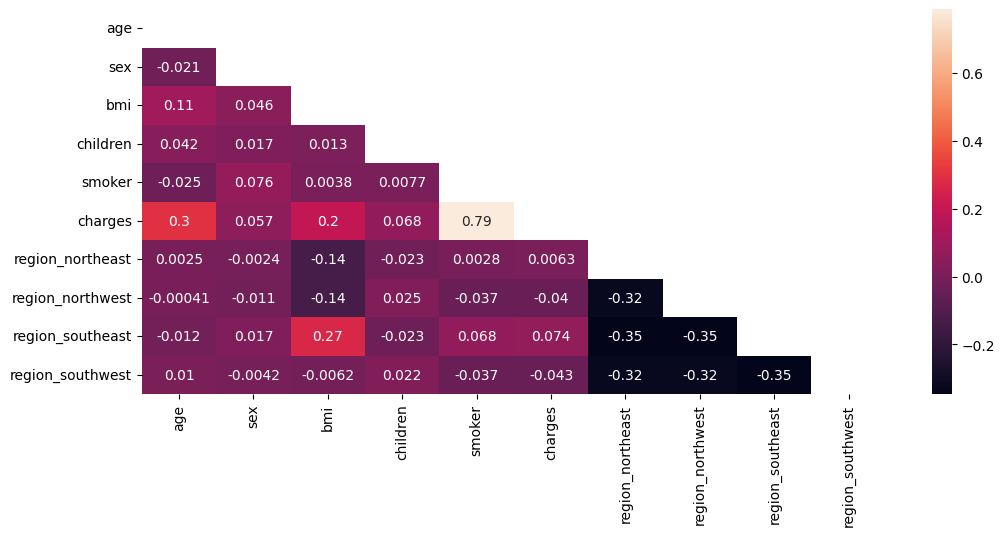

In [12]:
# Строим тепловую карту корреляций.
fig = plt.figure(figsize=(12, 5))
data_corr = data.corr()
# Выведем тепловую карту на основе матрицы корреляций.
matrix = np.triu(data_corr)
sns.heatmap(data_corr, annot=True, mask=matrix);

Анализ корреляций подтвердил наши ранние наблюдения: расходы на страховку и курение сильно связаны.

---

## Машинное обучение

---

In [13]:
# Выделим факторы и целевой признак в отдельные таблицы:
features = data.drop('charges', axis=1).columns
X, y = data[features], data['charges']

**Теперь мы можем начинать работу над моделью.**

Но прежде чем переходить к этапу моделирования, нам необходимо позаботиться о создании выборки для тестирования модели.

Разделим набор данных на тренировочную и тестовую выборки в соотношении 80/20. Воспользуемся для этого функцией train_test_split.

В качестве значения параметра random_state укажем *ответ на главный вопрос Жизни, Вселенной и Всего Остального*.

In [14]:
# Создаем тренировочную и тестовую выборки с помощью train_test_split.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # Таблица с наблюдениями и столбец с правильным ответами.
    test_size=0.2, # Размер тестовой выборки.
    random_state=42 # Число отвечающее за генерацию случайных чисел.
)
# Выводим размеры полученных выборок.
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1070, 9)
Test shape: (268, 9)


In [15]:
# Напишем функцию для вывода метрик.
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

Обучим модель линейной регрессии аналитическим методом (LinearRegression) на тренировочном наборе данных.
Все параметры оставим по умолчанию.

In [60]:
# Инициализируем объект класса линейная регрессия.
lr = linear_model.LinearRegression()
# Обучаем модель - ищем параметры.
lr.fit(X_train, y_train)
# Выведем значение свободного члена модели: как величина "поправки"
# это число может косвенно свидетельствовать о точности модели.
print(f'Величина свободного члена модели: {round(lr.intercept_, 3)}')

Величина свободного члена модели: -12390.804


С помощью обученной модели сделаем предсказание на тренировочной и тестовой выборках.<br>
Рассчитаем следующие три метрики: <i><b>R<sup>2</sup></b></i>, <i><b>MAE</b></i>, <i><b>MAPE</b></i>.<br>
Значение <i><b>MAPE</b></i> отобразим в процентах.

In [64]:
#Делаем предсказание для каждой из выборок
y_train_pred_lr = lr.predict(X_train)
y_test_pred_lr = lr.predict(X_test)
# Сохраним метрики.
lr_r2_score_test = metrics.r2_score(y_test, y_test_pred_lr)
lr_mae_test = metrics.mean_absolute_error(y_test, y_test_pred_lr)
lr_mape_test = metrics.mean_absolute_percentage_error(y_test, y_test_pred_lr)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred_lr, y_test, y_test_pred_lr)

Train R^2: 0.742
Train MAE: 4208.235
Train MAPE: 42.203


Test R^2: 0.784
Test MAE: 4181.194
Train MAPE: 46.888


Построем диаграмму boxplot для визуализации ошибок модели линейной регрессии на тренировочной и тестовой выборках.<br>
В качестве ошибки возьмем разницу между истинным ответом и предсказанием: $y - \widehat{y}$ (без модуля).

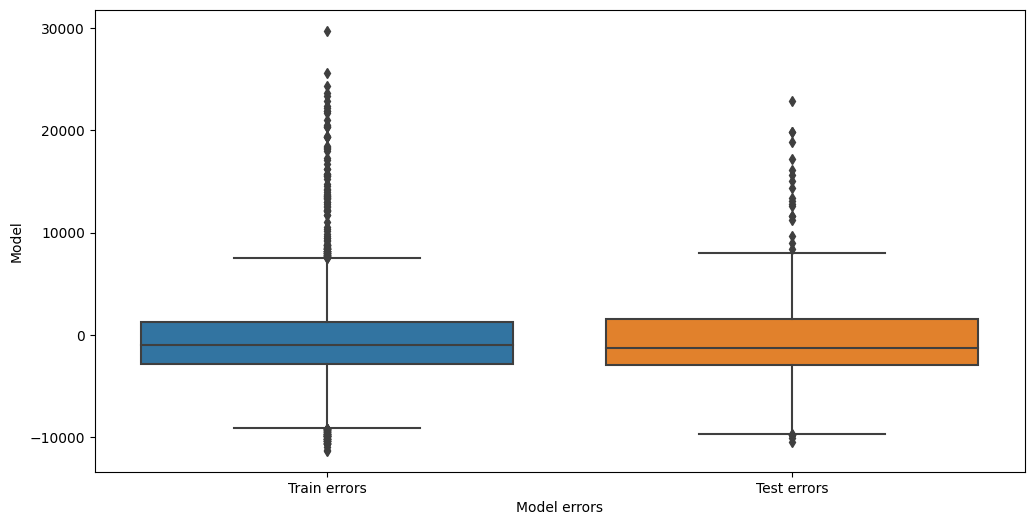

In [52]:
# Визуализируем ошибки.
fig, ax = plt.subplots(figsize=(12, 6)) # Фигура+координатная плоскость.
# Ошибки модели на тренировочной выборке.
y_train_errors = y_train - y_train_pred
# Ошибки модели на тестовой выборке.
y_test_errors = y_test - y_test_pred
# Для удобства визуализации составим DataFrame из ошибок.
predict_df = pd.DataFrame(
    {'Train errors': y_train_errors, 
     'Test errors': y_test_errors
    }
)
# Строим boxplot для ошибок.
sns.boxplot(data=predict_df, ax=ax)
ax.set_xlabel('Model errors')
ax.set_ylabel('Model');

Разброс ошибок на тренировочной выборке больше, чем на тестовой.<br>
Медианная ошибка на тренировочной и тестовой выборках отрицательная (меньше 0).

Нормализуем тренировочную и тестовую выборки с помощью *min*-*max*-нормализации (*MinMaxScaler*).<br>
Расчёт параметров нормализации (fit) произведем на тренировочной выборке.<br>
Min-max-нормализация не искажает изначальный вид бинарных категориальных признаков, в отличие от стандартизации.

In [53]:
# Создаем объект для min-max нормализации.
scaler = preprocessing.MinMaxScaler()
# Вычисляем параметры для нормализации - min и max для каждого столбца.
scaler.fit(X_train)
# Производим преобразование для каждой из выборок.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Попробуем переобучить модель на нормализованных данных.

In [65]:
# Инициализируем объект класса линейная регрессия.
lr_norm = linear_model.LinearRegression()
# Обучаем модель - ищем параметры.
lr_norm.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred_lr_norm = lr_norm.predict(X_train_scaled)
y_test_pred_lr_norm = lr_norm.predict(X_test_scaled)
# Сохраним метрики.
lr_norm_r2_score_test = metrics.r2_score(y_test, y_test_pred_lr_norm)
lr_norm_mae_test = metrics.mean_absolute_error(y_test, y_test_pred_lr_norm)
lr_norm_mape_test = metrics.mean_absolute_percentage_error(y_test, y_test_pred_lr_norm)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred_lr_norm, y_test, y_test_pred_lr_norm)
print('\n')
print(f'Величина свободного члена модели: {round(lr_norm.intercept_, 3)}')

Train R^2: 0.742
Train MAE: 4211.794
Train MAPE: 42.312


Test R^2: 0.783
Test MAE: 4190.615
Train MAPE: 47.118


Величина свободного члена модели: 2.7273995606224835e+17


На нормализованных данных сгенерируем полиномиальные признаки 2 степени.<br>
Воспользуемся классом PolynomialFeatures из библиотеки sklearn.<br>
Значение параметра include_bias выставим на False: тип нашей модели использует МНК, поэтому лишний столбец из единиц нам без надобности.

In [55]:
# Создаем объект для генерации полиномиальных признаков 2 степени.
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
# Вычисляем параметры генерации - результирующее количество признак.
poly.fit(X_train_scaled)
# Производим преобразование для каждой из выборок.
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 54)
Test shape: (268, 54)


Обучим модель линейной регрессии на полиномиальных признаках.<br>

In [66]:
# Инициализируем объект класса линейная регрессия.
lr_poly = linear_model.LinearRegression()
# Обучаем.
lr_poly.fit(X_train_scaled_poly, y_train)
# Делаем предсказание для каждой из выборок.
y_train_pred_lr_poly = lr_poly.predict(X_train_scaled_poly)
y_test_pred_lr_poly = lr_poly.predict(X_test_scaled_poly)
# Сохраним метрики.
lr_poly_r2_score_test = metrics.r2_score(y_test, y_test_pred_lr_poly)
lr_poly_mae_test = metrics.mean_absolute_error(y_test, y_test_pred_lr_poly)
lr_poly_mape_test = metrics.mean_absolute_percentage_error(y_test, y_test_pred_lr_poly)
# Выводим результирующие метрики.
print_metrics(y_train, y_train_pred_lr_poly, y_test, y_test_pred_lr_poly)
print('\n')
print(f'Величина свободного члена модели: {round(lr_poly.intercept_, 3)}')

Train R^2: 0.842
Train MAE: 2904.982
Train MAPE: 29.935


Test R^2: 0.867
Test MAE: 2744.170
Train MAPE: 30.748


Величина свободного члена модели: 1.0186407642736627e+17


Результаты уже лучше, но вот свободный член получился необычный.

Выведем значения коэффициентов полученной модели. Посмотрим на степени коэффициентов.

In [21]:
lr_poly.coef_

array([-3.35078495e+16,  1.78358281e+17,  1.64035044e+16, -1.08179882e+16,
       -2.41302853e+16, -7.37782096e+16, -3.14485544e+16, -6.91874439e+16,
       -6.22919615e+16,  8.51200000e+03,  8.64000000e+02,  1.06400000e+03,
       -1.89600000e+03,  2.44000000e+02,  3.35078495e+16,  3.35078495e+16,
        3.35078495e+16,  3.35078495e+16, -1.81407074e+17,  6.67000000e+02,
       -1.27600000e+03,  1.96000000e+02,  3.04879294e+15,  3.04879294e+15,
        3.04879294e+15,  3.04879294e+15, -9.67325000e+03,  1.68000000e+03,
        5.49650000e+04, -1.64035044e+16, -1.64035044e+16, -1.64035044e+16,
       -1.64035044e+16, -1.97600000e+03, -2.23400000e+03,  1.08179882e+16,
        1.08179882e+16,  1.08179882e+16,  1.08179882e+16,  2.08355712e+16,
        3.29471411e+15,  3.29471411e+15,  3.29471411e+15,  3.29471411e+15,
       -2.80858668e+16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -7.04155220e+16,  0.00000000e+00,  0.00000000e+00, -3.26766325e+16,
        0.00000000e+00, -

Значения коэффициентов очень высокие, что свидетельствует о неустойчивости модели. Необходима регуляризация.

Построим линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках.<br>
В качестве параметра alpha используем значение по умолчанию, параметр max_iter установим в значение 2000.

In [67]:
# Инициализируем объект класса линейная регрессия с L1-регуляризацией.
lasso_lr_poly = linear_model.Lasso(max_iter=2000)
# Обучаем модель.
lasso_lr_poly.fit(X_train_scaled_poly, y_train)
# Делаем предсказание для каждой из выборок.
y_train_pred_lasso_lr_poly = lasso_lr_poly.predict(X_train_scaled_poly)
y_test_pred_lasso_lr_poly = lasso_lr_poly.predict(X_test_scaled_poly)
# Сохраним метрики.
lasso_lr_poly_r2_score_test = metrics.r2_score(y_test, y_test_pred_lasso_lr_poly)
lasso_lr_poly_mae_test = metrics.mean_absolute_error(y_test, y_test_pred_lasso_lr_poly)
lasso_lr_poly_mape_test = metrics.mean_absolute_percentage_error(y_test, y_test_pred_lasso_lr_poly)
# Выводим результирующие метрики.
print_metrics(y_train, y_train_pred_lasso_lr_poly, y_test, y_test_pred_lasso_lr_poly)
print('\n')
print(f'Величина свободного члена модели: {round(lasso_lr_poly.intercept_, 3)}')

Train R^2: 0.842
Train MAE: 2890.473
Train MAPE: 29.401


Test R^2: 0.867
Test MAE: 2719.334
Train MAPE: 30.070


Величина свободного члена модели: 2249.714


In [23]:
# Выведем коэффициенты.
lasso_lr_poly.coef_

array([ 3.24221653e+03, -4.92313816e+02,  5.07612317e+03,  4.58362056e+03,
        1.97928569e+03,  1.88025707e+02, -4.70775218e+02,  5.83657101e+02,
       -2.43543456e+02,  8.29826751e+03,  7.74581954e+02,  8.44448593e+02,
       -1.20775688e+03,  1.34809915e+02, -1.04309726e+03, -0.00000000e+00,
        1.16964229e+03,  1.61765564e+03, -0.00000000e+00,  5.05847740e+02,
       -1.13425152e+03,  2.65796922e+02, -1.22240479e+03,  0.00000000e+00,
        2.36213242e+02, -5.80031340e+02, -8.17963257e+03,  1.29487768e+03,
        5.47148553e+04,  3.58531873e+03,  2.40690210e+03, -9.63549427e+02,
        0.00000000e+00, -1.67464337e+03, -2.05436459e+03,  1.94204864e+03,
        1.95394442e+03, -0.00000000e+00, -1.06364416e+03,  8.00606774e+00,
        5.93688978e+02, -0.00000000e+00, -2.30643423e+02,  1.97933477e+03,
        6.31615519e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -

Теперь постром линейную регрессию с L2-регуляризацией на полиномиальных признаках.<br>
В качестве параметра alpha также используем значение по умолчанию.

In [68]:
# Инициализируем объект класса линейная регрессия с L2-регуляризацией.
ridge_lr_poly = linear_model.Ridge()
# Обучаем модель предсказывать логарифм целевого признака.
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
# Делаем предсказание для каждой из выборок.
y_train_pred_ridge_lr_poly = ridge_lr_poly.predict(X_train_scaled_poly)
y_test_pred_ridge_lr_poly = ridge_lr_poly.predict(X_test_scaled_poly)
# Сохраним метрики.
ridge_lr_poly_r2_score_test = metrics.r2_score(y_test, y_test_pred_ridge_lr_poly)
ridge_lr_poly_mae_test = metrics.mean_absolute_error(y_test, y_test_pred_ridge_lr_poly)
ridge_lr_poly_mape_test = metrics.mean_absolute_percentage_error(y_test, y_test_pred_ridge_lr_poly)
# Выводим результирующие метрики.
print_metrics(y_train, y_train_pred_ridge_lr_poly, y_test, y_test_pred_ridge_lr_poly)
print('\n')
print(f'Величина свободного члена модели: {round(ridge_lr_poly.intercept_, 3)}')

Train R^2: 0.839
Train MAE: 2948.804
Train MAPE: 29.546


Test R^2: 0.863
Test MAE: 2860.555
Train MAPE: 31.380


Величина свободного члена модели: 2450.976


In [46]:
ridge_lr_poly.coef_

array([ 3.71983593e+03, -6.45028511e+02,  2.82475272e+03,  8.73944486e+02,
        6.84528883e+03,  1.81707480e+02,  8.52736212e+01, -1.40984164e+02,
       -1.25996936e+02,  4.31698578e+03,  7.72595933e+02,  2.39962018e+03,
        9.25678924e+02,  3.04523614e+03,  8.21576089e+02,  8.07056953e+02,
        9.82798103e+02,  1.10840479e+03, -6.45028511e+02,  1.27518173e+03,
       -6.85176951e+00,  2.93304450e+03, -3.83284913e+02,  3.57341619e+01,
       -5.98263543e+01, -2.37651406e+02,  1.63952722e+03,  1.28527988e+03,
        9.77468800e+03,  1.64183396e+03,  4.53024326e+02,  4.53736002e+02,
        2.76158428e+02,  1.70984275e+02,  4.43067588e+02,  8.86248734e+02,
        5.88275058e+02,  3.36219929e+01, -6.34201299e+02,  6.84528883e+03,
        1.63897806e+02,  4.90136575e+02,  3.31786997e+03,  2.87338448e+03,
        1.81707480e+02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.52736212e+01,  0.00000000e+00,  0.00000000e+00, -1.40984164e+02,
        0.00000000e+00, -

L2-регуляризация, как видим, сохраняет больше коэффициентов, хотя это вряд ли сделало нашу модель лучше. 

---

## Вывод

Мы проанализировали датасет, обработали его и обучили на нем модели линейной регрессии.

In [71]:
# Создадим таблицу получившихся значений метрик для тестовых выборок.
models = pd.DataFrame({
    'Model': ['LR', 'LR_norm', 'LR_poly', 'lasso_LR_poly','ridge_LR_poly'],
    'r2': [lr_r2_score_test, lr_norm_r2_score_test, lr_poly_r2_score_test,
           lasso_lr_poly_r2_score_test, ridge_lr_poly_r2_score_test],
    'mae': [lr_mae_test, lr_norm_mae_test, lr_poly_mae_test,
            lasso_lr_poly_mae_test, ridge_lr_poly_mae_test],
    'mape': [lr_mape_test, lr_norm_mape_test, lr_poly_mape_test,
             lasso_lr_poly_mape_test, ridge_lr_poly_mape_test]
})

# Отсортируем по MAPE.
models.sort_values(by = 'mape', ascending = False, inplace = True)
models

,Model,r2,mae,mape
1,LR_norm,0.783075,4190.615098,0.471177
0,LR,0.783593,4181.194474,0.468883
4,ridge_LR_poly,0.863338,2860.554540,0.313797
2,LR_poly,0.866811,2744.169956,0.307481
3,lasso_LR_poly,0.866807,2719.334130,0.300699


Наилучшего результата удалось получить нормализовав данные и регуляризовав функцию потерь lasso-методом.<br>
Однако величина ошибки остается довольно большй - 30%. Это явный признак того, что нам просто не хватает данных.